01 - Baseline Encoding Benchmark Code (Starting Code)

This Notebook is created for implementing the baseline categorical encoding benchmark for regression datasets. 

1. First step to setup the environment is to import the necessary tools.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder as SklearnOrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

# category encoders import
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


Now we have to load and prepare the data using try block, so we could find out the error, if there is one.

In [2]:
def load_data():
    # Loading and preparing ames dataset
    try:
        train_data = pd.read_csv("../data/raw/ames-housing-dataset/AmesHousing.csv", index_col=0)

        # preprocessing steps
        # filling the categorical features missing values
        cat_cols_before_exclusion = train_data.select_dtypes(include="object").columns.tolist()
        train_data[cat_cols_before_exclusion] = train_data[cat_cols_before_exclusion].fillna("missing")

        # filling the numerical features missing values
        num_cols_before_exclusion = train_data.select_dtypes(include="number").columns.to_list()
        train_data[num_cols_before_exclusion] = train_data[num_cols_before_exclusion].fillna(-1)  

        # excluding the useless columns from train data
        columns_to_exclude = ["Order", "PID", "SalePrice"]
        selected_columns = [col for col in train_data.columns if col not in columns_to_exclude]

        # Defining X and y (input and target value)
        X = train_data[selected_columns]
        y = train_data["SalePrice"]

        # column lists after exclusion
        cat_columns = X.select_dtypes(include="object").columns.tolist()
        num_columns = X.select_dtypes(include="number").columns.tolist()

        # return the train data
        return X, y, cat_columns, num_columns
        

    except FileNotFoundError:
        print("Dataset was not found!")
        return None

In [3]:
# assigning the variables
X, y, cat_columns, num_columns = load_data()

Now we have to define a baseline benchmark class, that we could reuse.

In [4]:
class EncodingBenchmark:
    """
    Starting baseline to test core encoder-algorithm interactions by going through 4 Senarios as described below:
    1. No column removal, no encoding (baseline with raw data)
    2. No column removal, with encoding
    3. Column removal, no encoding (feature selection only)
    4. Column removal, with encoding (optimized pipeline)
    
    Tests 3 encoders named OneHotEncoder, TargetEncoder, OrdinalEncoder with 2 representative algorithms named Ridge and RandomForest to validate the fundamental hypothesis that encoding choice affects performance. 
    """
    
    # defining the init
    def __init__(self, random_state = 42):
        self.random_state = random_state

        # encoders
        self.encoders = {
            "OneHotEncoder" : OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
            "TargetEncoder" : ce.TargetEncoder(smoothing=1),
            "OrdinalEncoder" : SklearnOrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
        }

        # machine learning algorithms
        self.algorithms = {
            "Ridge" : Ridge(random_state=self.random_state),
            "RandomForest" : RandomForestRegressor(n_estimators=50, random_state=self.random_state)
        }

    # selecting more relevant feautures
    def feature_selection(self, X, y, cat_columns, num_columns, threshold=0.3):
         """In this method, we remove the number columns that have low varience and the categorical columns that have a unique value."""

         # making a copy of numerical and categorical features
         X_cat = X[cat_columns].copy()
         X_num = X[num_columns].copy()

         # applying the variance threshold to the numerical columns
         variance_threshold = VarianceThreshold(threshold=threshold)
         X_num_selected = variance_threshold.fit_transform(X_num)
         selected_num_columns = X_num.columns[variance_threshold.get_support()].tolist()

         # removing categorical columns, that have only one unique value
         selected_cat_columns = [col for col in cat_columns if X_cat[col].nunique() > 1]

        # Concatinating the columns
         X_reduced = pd.concat([
              X_cat[selected_cat_columns].reset_index(drop=True),
              pd.DataFrame(X_num_selected, columns = selected_num_columns)
         ], axis=1)

         print(f"Feature selection: {len(X.columns)} -> {len(X_reduced.columns)} features")
         print(f"  Categorical: {len(cat_columns)} -> {len(selected_cat_columns)}")
         print(f"  Numerical: {len(num_columns)} -> {len(selected_num_columns)}")
        
         return X_reduced, selected_cat_columns, selected_num_columns




    # creating pipeline
    def create_pipeline(self, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=True):
            """Create preprocessing and algorithming pipeline with optional encoding."""
            
            algorithm = self.algorithms[algorithm_name]

            # if condition for applying encoding or not
            if apply_encoding:
                 # In this case, it is scenario 2 or 4, which encoding is enabled in them
                 encoder = self.encoders[encoder_name]
                 #preprocessor
                 preprocessor = ColumnTransformer([
                 ("categorical", encoder, cat_columns),
                 ("numerical", StandardScaler(), num_columns)
            ])
            # Scenario 1 and 3, without any encoding     
            else:
                 # since sklearn does not understand categorical columns (texts), we have to choose a minimal encoder (ordinal encoder) so that we could run the sklearn without getting an error.
                 minimal_encoder = SklearnOrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
                 preprocessor = ColumnTransformer([
                 ("categorical", minimal_encoder, cat_columns),
                 ("numerical", StandardScaler(), num_columns)
                ])

            #pipeline implementation
            pipeline = Pipeline([
                ("preprocessor", preprocessor),
                ("algorithm", algorithm)
            ])
            return pipeline
        
    def evaluate_combination(self, X, y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=True, scenario = ""):
            """Evaluate one single combination of encoder and algorithm in a specific scenario."""

            try:
                # create an object of the class Pipeline
                new_pipeline = self.create_pipeline(encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding)

                # define 5-fold cross validation CV
                cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=self.random_state)

                # Evaluation metrics
                rmse = -cross_val_score(new_pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
                rmse = np.sqrt(rmse)

                # results
                result = {
                'scenario': scenario,
                'encoder': encoder_name,
                'algorithm': algorithm_name,
                'rmse_mean': rmse.mean(),
                'rmse_std': rmse.std(),
                'number_features' : X.shape[1]
                }
            
                return result

            except Exception as e:
                print(f"There is an error with the combination of algorithm {algorithm_name} and the encoder {encoder_name} in {scenario}")
                return None
            
    def run_scenarios(self,X, y, cat_columns, num_columns):
         """Running four different scenarios, as described above."""
         results =[]

         # Scenario 1: no feature selection and no encoding
         print( " Running Scenario 1: No feature selection and no encoding")
         for encoder_name in self.encoders.keys():
              for algorithm_name in self.algorithms.keys():
                   print(f"Testing: {algorithm_name} + {encoder_name}")
                   result = self.evaluate_combination(X,y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=False,scenario="S1_No_Selection_No_Encoding")
                   if result:
                        results.append(result)
                        print(f"RMSE: {result['rmse_mean']:,.0f}")

        # Scenario 2: no feature selection but with encoding
         print("Running Scenario 2: no feature selection, with encoding")
         for encoder_name in self.encoders.keys():
              for algorithm_name in self.algorithms.keys():
                   print(f"Testing: {algorithm_name} + {encoder_name}")
                   result = self.evaluate_combination(X,y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=True,scenario="S2_No_Selection_With_Encoding")
                   if result:
                        results.append(result)
                        print(f"RMSE: {result['rmse_mean']:,.0f}")
        
        # Running Feature selection for Scenario 3 and 4
         X_reduced, cat_reduced, num_reduced = self.feature_selection(
            X, y, cat_columns, num_columns
         )
        # Scenario 3: With feature selection but no encoding
         print("Running Scenario 3: With feature selection, no encoding")
         for encoder_name in self.encoders.keys():
              for algorithm_name in self.algorithms.keys():
                   print(f"Testing: {algorithm_name} + {encoder_name}")
                   result = self.evaluate_combination(X,y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=False,scenario="S3_With_Selection_No_Encoding")
                   if result:
                        results.append(result)
                        print(f"RMSE: {result['rmse_mean']:,.0f}")
        # Scenario 4: With feature selection and encoding
         print("Running Scenario 4: With feature selection and encoding")
         for encoder_name in self.encoders.keys():
              for algorithm_name in self.algorithms.keys():
                   print(f"Testing: {algorithm_name} + {encoder_name}")
                   result = self.evaluate_combination(X,y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=True,scenario="S4_With_Selection_With_Encoding")
                   if result:
                        results.append(result)
                        print(f"RMSE: {result['rmse_mean']:,.0f}")
         return pd.DataFrame(results)

        
    # run the baseline test
    ## def run_baseline_test(self, X, y, cat_columns, num_columns):        
        
           ## results = []
        
          #  for encoder_name in self.encoders.keys():
               # for algorithm_name in self.algorithms.keys():
                   # print(f"Testing: {encoder_name} + {algorithm_name}")
                
                    #result = self.evaluate_combination(
                      #  X, y, encoder_name, algorithm_name, cat_columns, num_columns
                 #   )
                
                   # if result:
                     #   results.append(result)
                    #    print(f"  RMSE: {result['rmse_mean']:,.0f} (±{result['rmse_std']:,.0f})")

        
           ## return pd.DataFrame(results)
             ##
  
    # analyze the results (RMSE)
    def analyze_results(self, results_df):
        """analyze  results to validate core hypothesis across all four scenarios."""
        
        # Overall best by scenario
        print("\nBest Performance by Scenario:")
        for scenario in results_df['scenario'].unique():
            scenario_data = results_df[results_df['scenario'] == scenario]
            best = scenario_data.loc[scenario_data['rmse_mean'].idxmin()]
            print(f"{scenario}: {best['encoder']} + {best['algorithm']} = {best['rmse_mean']:,.0f}")
        
        # Compare scenarios
        print("\nScenario Comparison (Average RMSE across all combinations):")
        scenario_avg = results_df.groupby('scenario')['rmse_mean'].mean().sort_values()
        for scenario, avg_rmse in scenario_avg.items():
            print(f"{scenario}: {avg_rmse:,.0f}")
        
        # Impact of feature selection
        with_selection = results_df[results_df['scenario'].str.contains('With_Selection')]['rmse_mean'].mean()
        without_selection = results_df[results_df['scenario'].str.contains('No_Selection')]['rmse_mean'].mean()
        print(f"\nFeature Selection Impact:")
        print(f"  With Selection: {with_selection:,.0f}")
        print(f"  Without Selection: {without_selection:,.0f}")
        print(f"  Difference: {without_selection - with_selection:,.0f}")
        
        # Impact of encoding
        with_encoding = results_df[results_df['scenario'].str.contains('With_Encoding')]['rmse_mean'].mean()
        without_encoding = results_df[results_df['scenario'].str.contains('No_Encoding')]['rmse_mean'].mean()
        print(f"\nEncoding Impact:")
        print(f"  With Encoding: {with_encoding:,.0f}")
        print(f"  Without Encoding: {without_encoding:,.0f}")
        print(f"  Difference: {without_encoding - with_encoding:,.0f}")
        
        return results_df   
    
    # visualize the results for more comprehensive analysis of the RMSE 
    def visualize_results(self, results_df):
        """Create visualizations comparing the 4 scenarios."""
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle("4-Scenario Benchmark: Feature Selection × Encoding Impact", 
                    fontsize=18, fontweight='bold')
        
        # 1. Scenario comparison
        scenario_avg = results_df.groupby('scenario')['rmse_mean'].mean().sort_values()
        axes[0,0].barh(scenario_avg.index, scenario_avg.values, color='steelblue')
        axes[0,0].set_xlabel('Average RMSE ($)')
        axes[0,0].set_title('Average Performance by Scenario')
        axes[0,0].invert_yaxis()
        
        # 2. Encoder performance across scenarios
        encoder_scenario = results_df.groupby(['encoder', 'scenario'])['rmse_mean'].mean().unstack()
        encoder_scenario.plot(kind='bar', ax=axes[0,1], rot=45)
        axes[0,1].set_ylabel('RMSE ($)')
        axes[0,1].set_title('Encoder Performance Across Scenarios')
        axes[0,1].legend(title='Scenario', fontsize=8)
        
        # 3. Algorithm performance across scenarios
        algo_scenario = results_df.groupby(['algorithm', 'scenario'])['rmse_mean'].mean().unstack()
        algo_scenario.plot(kind='bar', ax=axes[1,0], rot=45)
        axes[1,0].set_ylabel('RMSE ($)')
        axes[1,0].set_title('Algorithm Performance Across Scenarios')
        axes[1,0].legend(title='Scenario', fontsize=8)
        
        # 4. Feature count vs RMSE
        for scenario in results_df['scenario'].unique():
            scenario_data = results_df[results_df['scenario'] == scenario]
            axes[1,1].scatter(scenario_data['number_features'], scenario_data['rmse_mean'], 
                            label=scenario, alpha=0.6, s=100)
        axes[1,1].set_xlabel('Number of Features')
        axes[1,1].set_ylabel('RMSE ($)')
        axes[1,1].set_title('Feature Count vs Performance')
        axes[1,1].legend(fontsize=8)
        
        plt.tight_layout()
        plt.savefig('../results/four_scenario_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nVisualization saved to 'results/four_scenario_comparison.png'")









Now we have to define a if condition to run the baseline test using the class defined above.

 Running Scenario 1: No feature selection and no encoding
Testing: Ridge + OneHotEncoder
RMSE: 32,003
Testing: RandomForest + OneHotEncoder
RMSE: 25,892
Testing: Ridge + TargetEncoder
RMSE: 32,003
Testing: RandomForest + TargetEncoder
RMSE: 25,892
Testing: Ridge + OrdinalEncoder
RMSE: 32,003
Testing: RandomForest + OrdinalEncoder
RMSE: 25,892
Running Scenario 2: no feature selection, with encoding
Testing: Ridge + OneHotEncoder
RMSE: 29,115
Testing: RandomForest + OneHotEncoder
RMSE: 25,964
Testing: Ridge + TargetEncoder
RMSE: 30,021
Testing: RandomForest + TargetEncoder
RMSE: 25,685
Testing: Ridge + OrdinalEncoder
RMSE: 32,003
Testing: RandomForest + OrdinalEncoder
RMSE: 25,892
Feature selection: 79 -> 75 features
  Categorical: 43 -> 43
  Numerical: 36 -> 32
Running Scenario 3: With feature selection, no encoding
Testing: Ridge + OneHotEncoder
RMSE: 32,003
Testing: RandomForest + OneHotEncoder
RMSE: 25,892
Testing: Ridge + TargetEncoder
RMSE: 32,003
Testing: RandomForest + TargetEnco

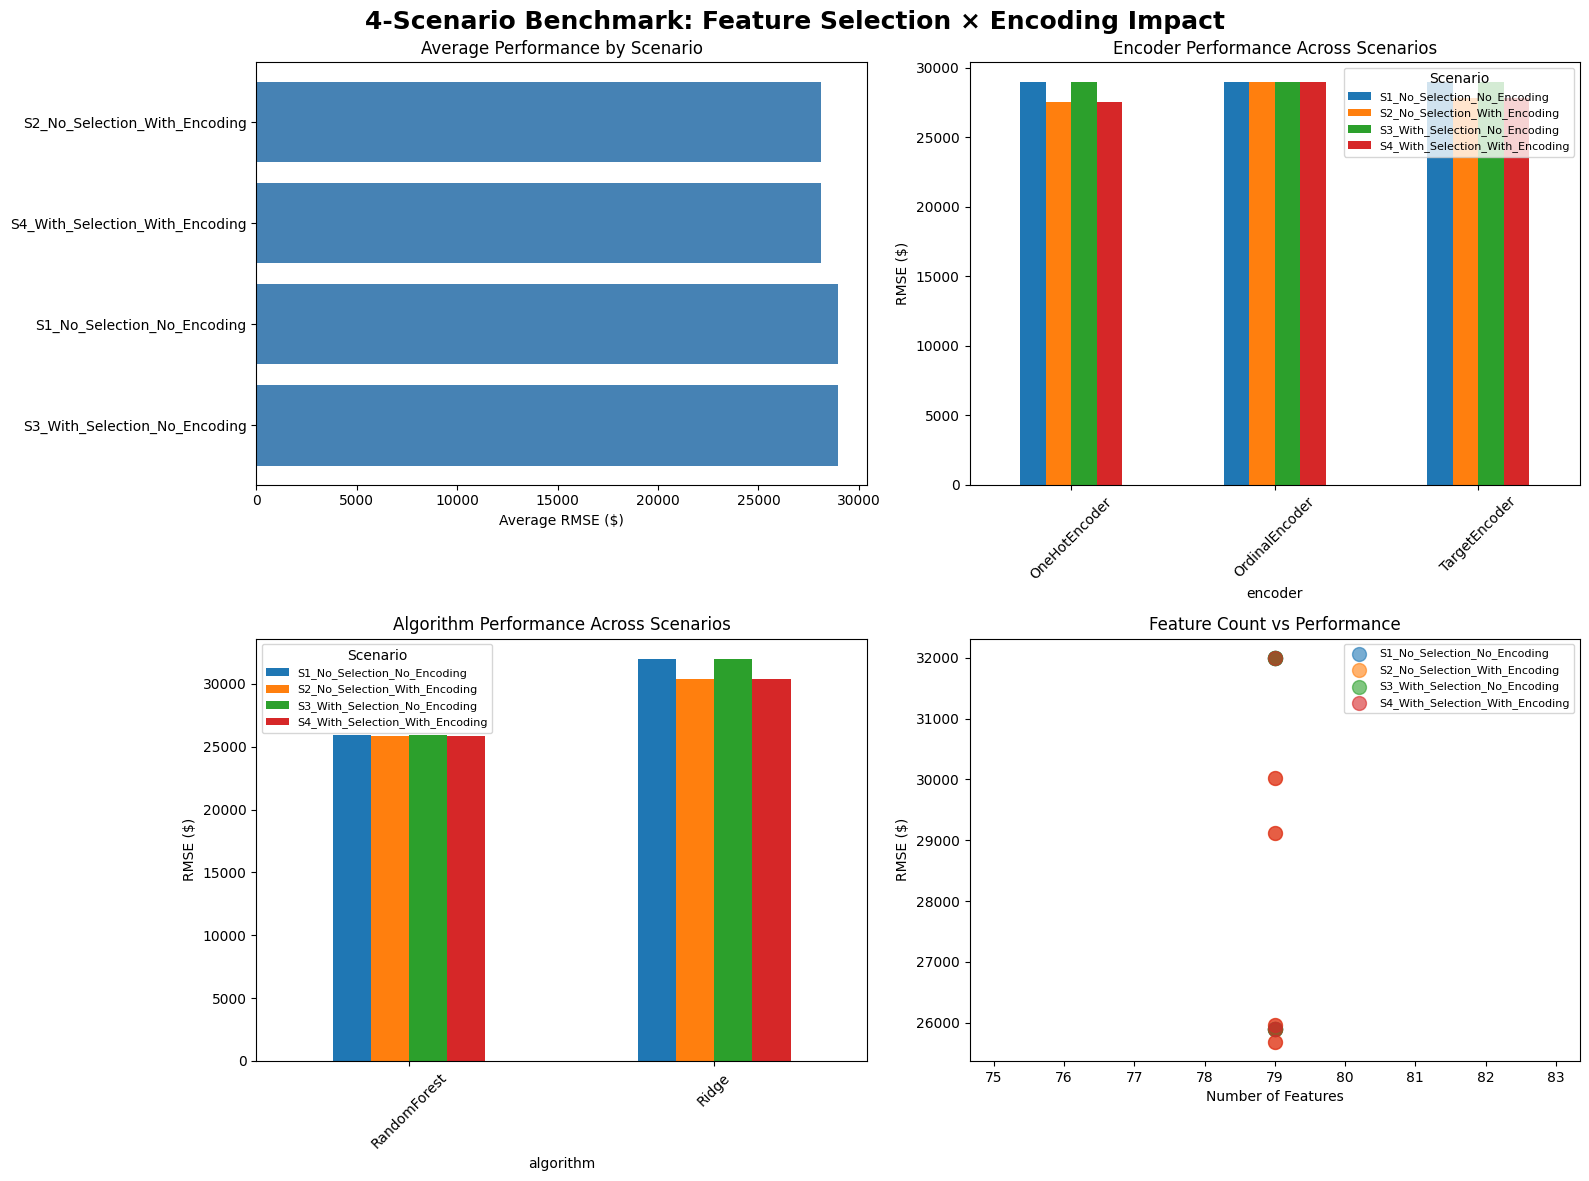


Visualization saved to 'results/four_scenario_comparison.png'

Results saved to baseline_test_results.csv


In [5]:
# ## Run Baseline Test

if X is not None:
    # Initialize and run baseline
    baseline = EncodingBenchmark(random_state=42)
    
    # Run the test
    results = baseline.run_scenarios(X, y, cat_columns, num_columns)
    
    # Analyze results
    analysis = baseline.analyze_results(results)

    # visualize results
    baseline.visualize_results(results)

    
    # Save results
    results.to_csv('../results/baseline_test_results.csv', index=False)
    print(f"\nResults saved to baseline_test_results.csv")